## Introduction
This notebook uses a dataset of recipes and ingredients to predict the star rating.  The star rating is a value given by reviewers of variaous food recipes.  There are about 20,000 rows and 680 columns (or 680 possible features).  We will decrease the number of features to the best 30 using support vector machines as a binary classifier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
%matplotlib inline

## Import and clean the data

In [2]:
raw_data = pd.read_csv(r'C:\Users\Fred\Downloads\epi_r.csv', error_bad_lines=False)

In [3]:
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
raw_data.tail()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
20047,Parmesan Puffs,3.125,28.0,2.0,2.0,64.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20048,Artichoke and Parmesan Risotto,4.375,671.0,22.0,28.0,583.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20049,Turkey Cream Puff Pie,4.375,563.0,31.0,38.0,652.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20050,Snapper on Angel Hair with Citrus Cream,4.375,631.0,45.0,24.0,517.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20051,Baked Ham with Marmalade-Horseradish Glaze,4.375,560.0,73.0,10.0,3698.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
raw_data.sample()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
595,White Fish Terrine with Salmon Roe and Dill,2.5,265.0,12.0,24.0,721.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
raw_data.dtypes.head()

title        object
rating      float64
calories    float64
protein     float64
fat         float64
dtype: object

This data looks to be already in very good shape.  No cleaning is necessary at this point.

## Data exploration and data analysis
Let's start with a histogram of all of the ratings which is the target feature we are trying to predict.

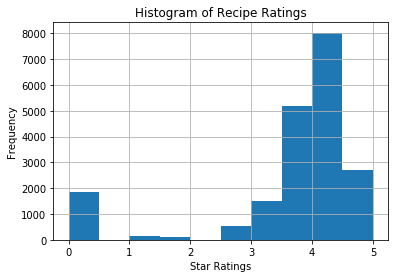

In [6]:
raw_data.rating.hist()
plt.title('Histogram of Recipe Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Frequency')
plt.show()

This histogram shows the distribution for all of the ratings.  The data is not continuous and has a high number of stars at zero.  The biggest question here:  Are these ratings of zero meant by the reviewer to have a score of zero or did they forget to give a rating ?  Instead of giving a rating of 2 or 3, maybe the reviewer just thought it was easier to leave the rating blank.  This unknown will complicate our model.

As a next step, let's just look at one of the features, 'cocktail' and its histogram.

In [7]:
df_cocktail = raw_data.loc[raw_data['cocktail'] == 1.0]

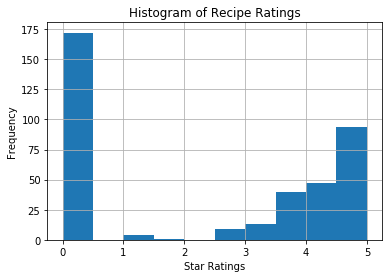

In [8]:
df_cocktail.rating.hist()
plt.title('Histogram of Recipe Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Frequency')
plt.show()

So here again, we have a very large number of ratings of zero.  This is troubling.  It's difficult to know what the reviewer is thinking.  Did they just not feal like chosing a star and leave the rating blank ?

In [9]:
df_drink = raw_data.loc[raw_data['drink'] == 1.0]
df_drink[['rating', 'drink']].head(10)

,rating,drink
42,0.000,1.0
115,5.000,1.0
116,5.000,1.0
119,2.500,1.0
131,0.000,1.0
143,3.125,1.0
194,5.000,1.0
198,5.000,1.0
211,0.000,1.0
218,2.500,1.0


The above table just shows a different format of the 'drink' feature, its ratings and some of the row numbers of where 'drink' is present.  

Next, we look at a lising of all of the columns and datatypes of the dataset.

In [10]:
# show some of the columns of the dataset
raw_data.columns

Index(['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek',
       '#wasteless', '22-minute meals', '3-ingredient recipes',
       ...
       'yellow squash', 'yogurt', 'yonkers', 'yuca', 'zucchini', 'cookbooks',
       'leftovers', 'snack', 'snack week', 'turkey'],
      dtype='object', length=680)

In [11]:
raw_data.dtypes.value_counts()

float64    679
object       1
dtype: int64

## Building the model
In this case, we'll use the Support Vector model as a Classifier (SVC).  We will classify the rating to be either 0, 1, 2, 3, 4 or 5.  In order to pick the best 30 features (which was a requirement from the instructions), we will use the SelectKBest method which scores all of the features based on the chi-squared statistic and returns the the best number of k features.

In [12]:
from sklearn.svm import SVR
from sklearn.svm import SVC

svc = SVC()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
X = X.astype(int)

Y = raw_data['rating']
Y = Y.astype(int)

selector = SelectKBest(chi2, k=10)
selector.fit(X, Y)

X_new = selector.transform(X)
print(X_new.shape)

X.columns[selector.get_support(indices=True)]

# 1st way to get the list
vector_names = list(X.columns[selector.get_support(indices=True)])
print(vector_names)

#print(svr.score(X_new, Y))

score = cross_val_score(svc, X_new, Y, cv=5)
print(score)
print(score.mean())

(20052, 10)
['alcoholic', 'bitters', 'cocktail', 'cocktail party', 'drink', 'gin', 'harpercollins', 'house & garden', 'liqueur', 'spirit']


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", F

[0.414154   0.41550349 0.42383446 0.419556   0.4205141 ]
0.418712408721554


This model produced the best 10 features in order to explore thest 10 graphically with a histogram and pairplot to see if we notice anything unique or different about these 10 features compared to the entire dataset.  Already, you can see that the best predictors involve alcohol (with a 'house & garden' feaure thrown in.  Maybe this could be due to the fact that people making dishes with alcohol are happier and want to give better ratings.  Maybe the alcohol affects their mood and they give it a high rating, thus these features have a high predictive value.

In [13]:
data_10 = raw_data[['rating', 'alcoholic', 'bitters', 'cocktail', 'cocktail party', 
                   'drink', 'gin', 'harpercollins', 'house & garden', 'liqueur', 'spirit']].copy()

In [14]:
data_10.head()

,rating,alcoholic,bitters,cocktail,cocktail party,drink,gin,harpercollins,house & garden,liqueur,spirit
0,2.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


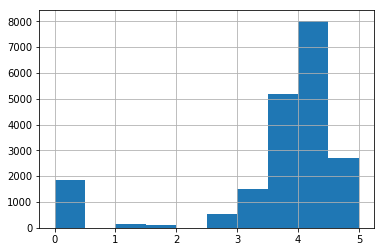

In [15]:
data_10.rating.hist()

The above histogram is just for the 10 most relevent feautures out of the approximately 350 features in the original dataset.  This histogram doesn't show anything that looks too surprising.

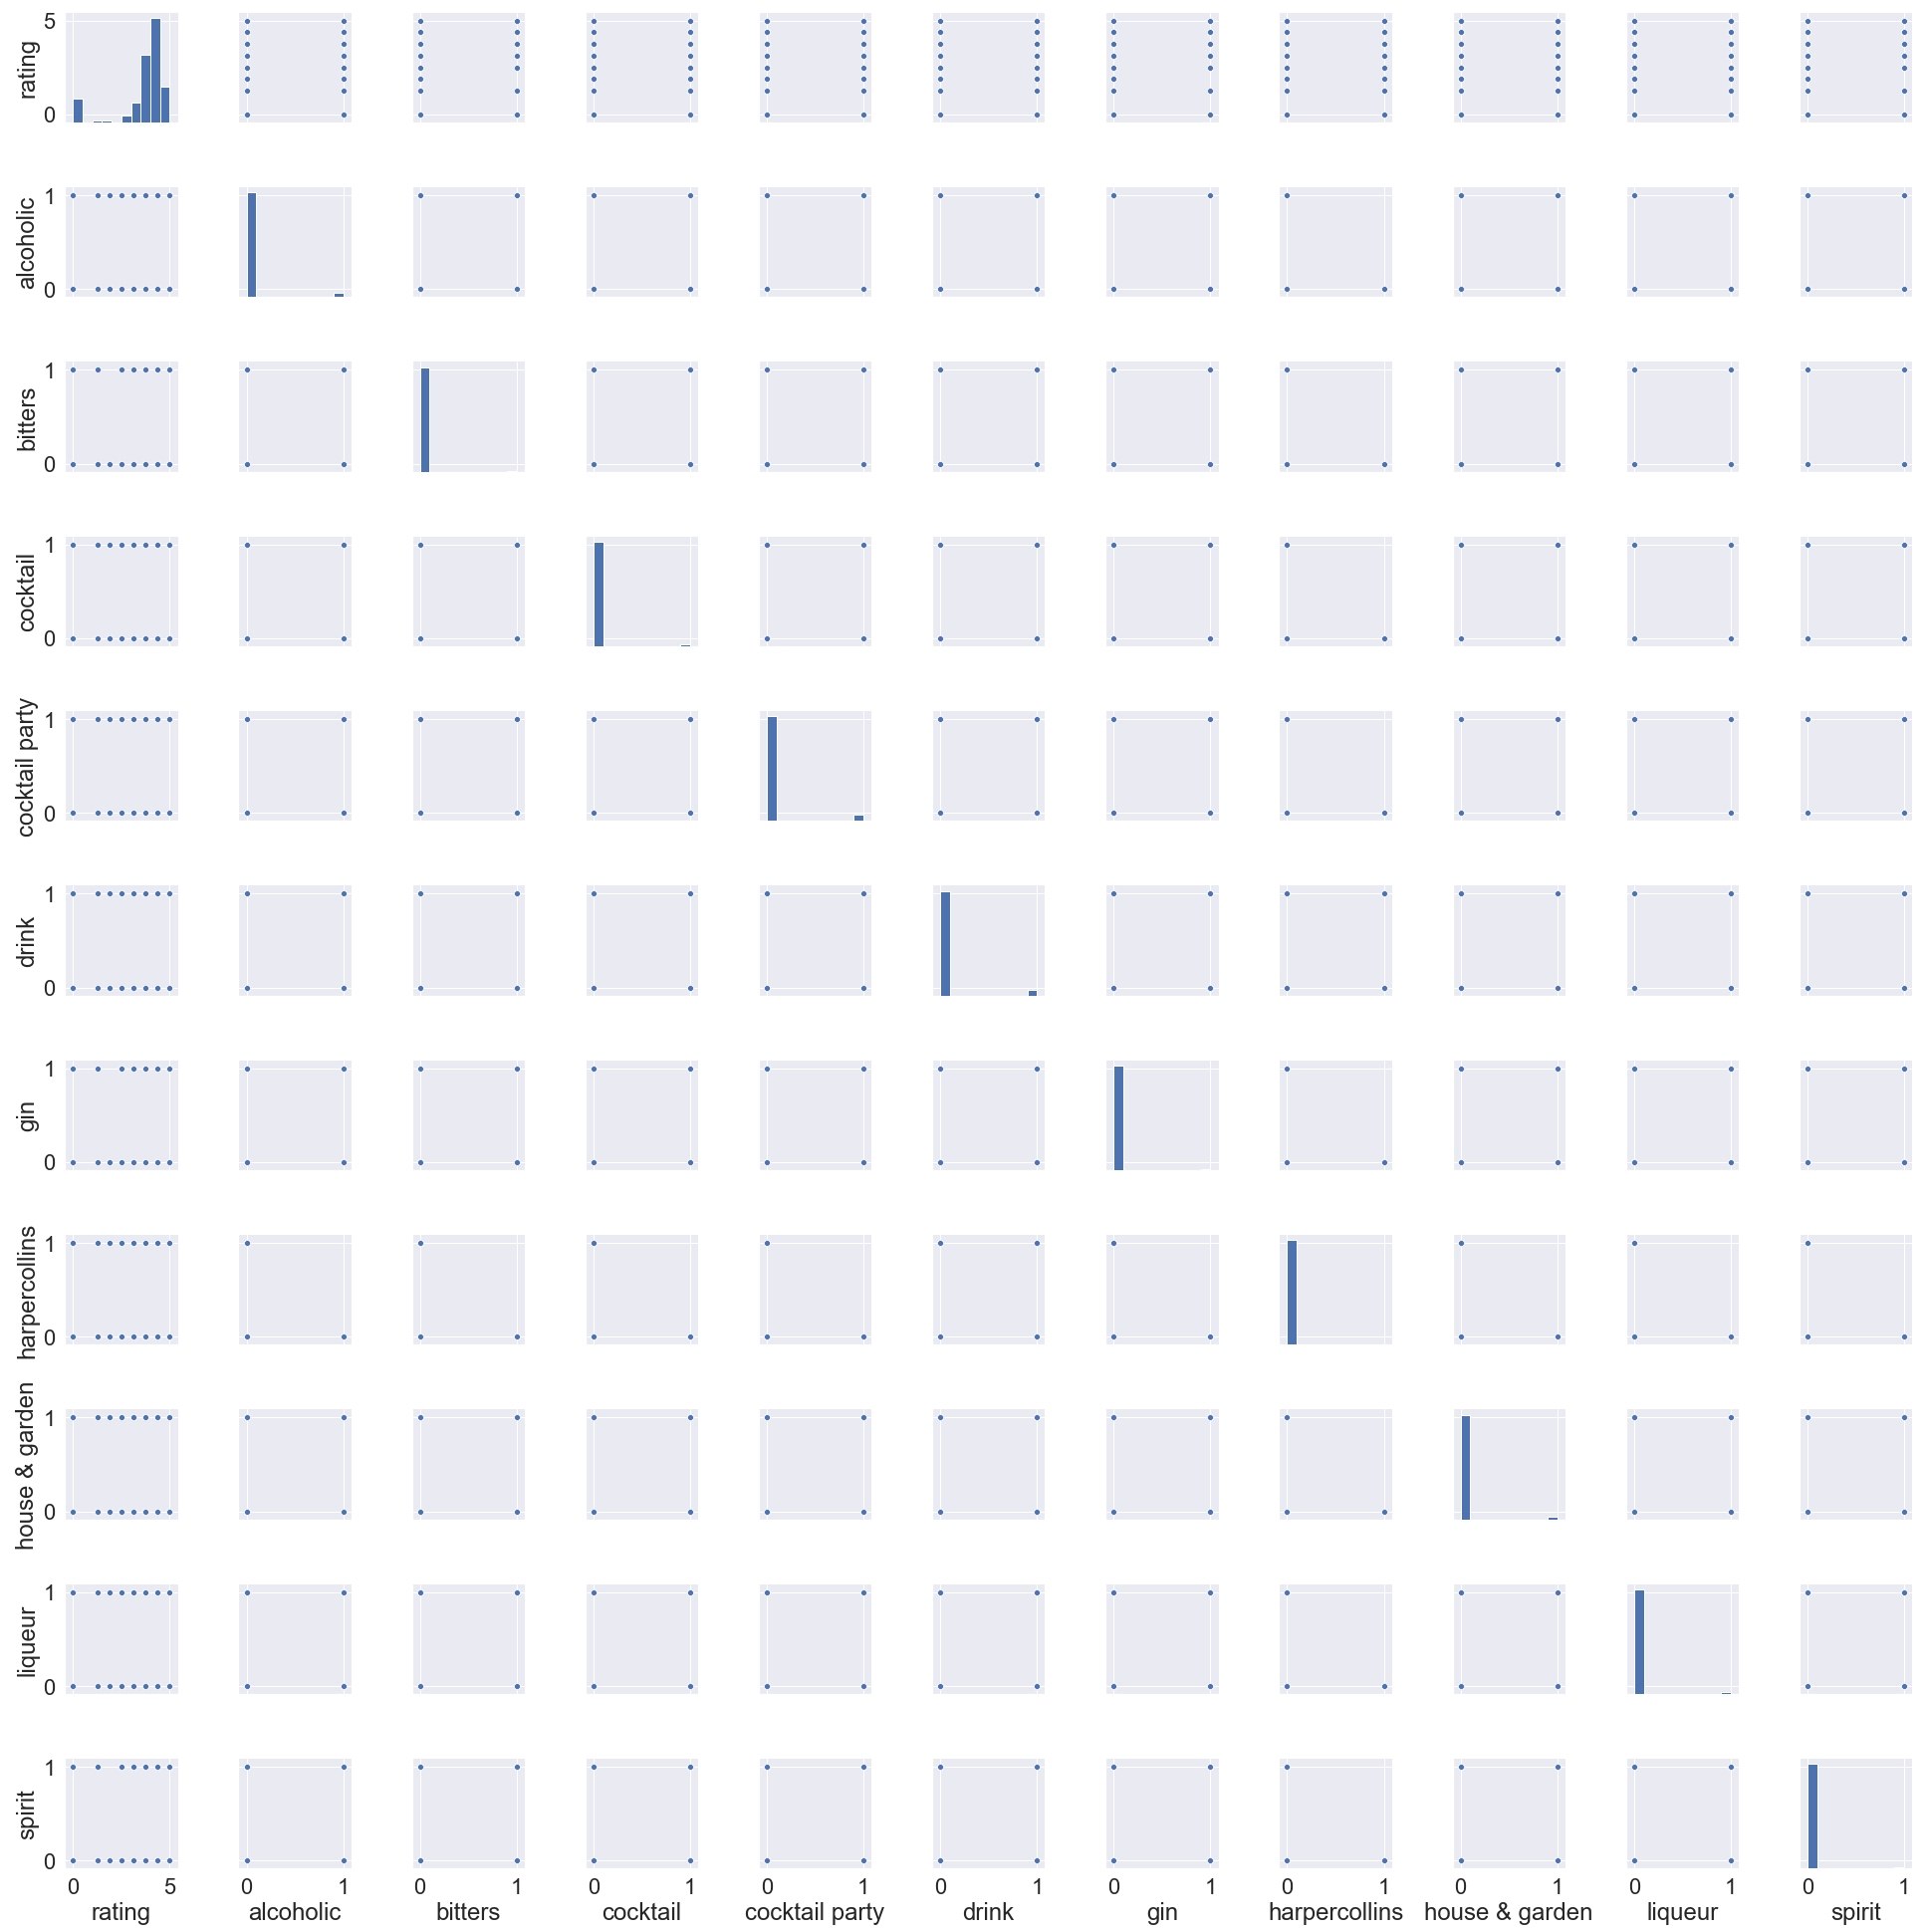

In [16]:
sns.set(font_scale=2.0)
sns.pairplot(data_10)

Nothing too interesting with the above pairplot for the 10 best features.

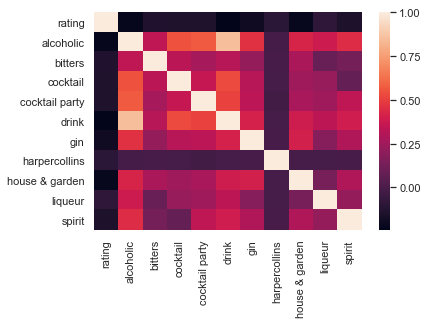

In [17]:
sns.set(font_scale=1.0)
sns.heatmap(data_10.corr())

This heatmap is kind of interesting.  It shows the very poor correlation between rating and any of the 10 best features.  Looks like pridicting the rating from the data given will be difficult.  

Let's run the model one more time selecting the best 30 features and measuring the accuracy.

In [18]:
# split the data into training and test sets
trainsize = int(raw_data.shape[0] / 4)
df_train = raw_data.iloc[trainsize:, :].copy()
df_test = raw_data.iloc[:trainsize, :].copy()

In [19]:
df_test.tail()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
5008,Link Family Crawfish Boil,0.000,1312.0,234.0,15.0,8945.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5009,Teriyaki Tofu Triangles,3.750,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5010,Rugelach,4.375,105.0,1.0,6.0,37.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5011,Chunky Two-Cheese Potatoes with Garlic and Pesto,3.750,302.0,11.0,16.0,181.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5012,Strawberry and Cream Cake with Cardamom Syrup,4.375,405.0,6.0,15.0,163.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.svm import SVR
from sklearn.svm import SVC

# split the data into training and test sets
trainsize = int(raw_data.shape[0] / 4)
df_train = raw_data.iloc[trainsize:, :].copy()
df_test = raw_data.iloc[:trainsize, :].copy()

svc = SVC()
X = df_train.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
X = X.astype(int)

Y = df_train['rating']
Y = Y.astype(int)

selector = SelectKBest(chi2, k=30)
selector.fit(X, Y)

X_new = selector.transform(X)
print(X_new.shape)

X.columns[selector.get_support(indices=True)]

# 1st way to get the list
vector_names = list(X.columns[selector.get_support(indices=True)])
print(vector_names)

#print(svr.score(X_new, Y))
score = cross_val_score(svc, X_new, Y, cv=5)
print(score)
print(score.mean())

# now set the X and Y for the test set
X_T = df_test[vector_names]
X_T = X.astype(int)

Y_T = df_test['rating']
Y_T = Y.astype(int)

#print(svr.score(X_new, Y))
score = cross_val_score(svc, X_T, Y_T, cv=5)
print(score)
print(score.mean())

(15039, 30)
['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'champagne', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'drink', 'fall', 'fruit juice', 'gin', 'gourmet', 'harpercollins', 'house & garden', 'lime juice', 'liqueur', 'non-alcoholic', 'party', 'pasta', 'pernod', 'quick & easy', 'roast', 'rum', 'sauté', 'spirit', 'vegetable', 'winter']


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", F

[0.41813351 0.43403124 0.42733622 0.42947438 0.4241517 ]
0.42662540934885895


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", F

[0.41215543 0.41674975 0.41503159 0.41250832 0.41417166]
0.4141233494347544


## Evaluating the model
10-feature model:
- features:  'alcoholic', 'bitters', 'cocktail', 'cocktail party', 'drink', 'gin', 'harpercollins', 'house & garden', 'liqueur', 'spirit'  

- cross-val scores:  0.414154, 0.41550349, 0.42383446, 0.419556, 0.4205141  
- average cross-val score:  **0.419**  

30-feature model:
- features:  'alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'champagne', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'drink', 'fall', 'fruit juice', 'gin', 'gourmet', 'harpercollins', 'house & garden', 'lime juice', 'liqueur', 'non-alcoholic', 'party', 'pasta', 'pernod', 'quick & easy', 'roast', 'rum', 'sauté', 'spirit', 'vegetable', 'winter'  

- Training set - 75% of data
    - cross-val scores:  0.41813351, 0.43403124, 0.42733622, 0.42947438, 0.4241517
    - average cross-val score:  **0.427**  

- Test set - 25% of data  
    - cross-val scroes:  0.41215543, 0.41674975, 0.41503159, 0.41250832, 0.41417166  
    - average cross-val score:  **0.414**  



## Conclusion and discussion
First of all, this notebook took about 20 minutes to run on a laptop with 6 gig of RAM.  Secondly, the overall accuracy was not bad considering the possible bias of the data.  Using just 10 features, we obtained an average accuracy of .419, while using 30 features we had an accuracy of .427 - slightly better.  The best part about this model is that there apprears to be very little overfitting.  The **test set accuracy was calculated to be .414** - just slightly lower than the training set calculation.  

The possible bias in these models are the large number of zero rating scores.  More study is needed to determine why zero is such a popular rating.  

We did also find that the accuracy of the model increased drastically by using SVM as a 'classifier' as opposed to a 'regression'.  In the course demonstration (using regression), the average cross-val score was .024; our classification model yielded much, much better accuracy - almost **17 times more accurate**.  However, it should be noted that the class demo used all of the features / columns - possibly adding a lot of noise to the data.